In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['font.size'] = 14

cities_label = {"London":"london", 
                "New York":"newyork", 
                "Beijing":"beijing",
                "Hong Kong":"hongkong",
                "Singapore":"singapore"}

In [2]:
def cost_benefit(P_ac, P_heat, tbuild):
    #w=0.1
    #r = -w*1*(P_ac + P_heat) - (1-w)*1*(abs(tbuild - 24 - 273.15) + abs(tbuild - 18 - 273.15))
    P_ac = P_ac/3.6/0.43
    P_heat = P_heat/0.9/0.96
    r = (P_ac + P_heat)/(-1*(abs(tbuild - 24 - 273.15) + abs(tbuild - 18 - 273.15)) + 100)
    return r

def cost(P_ac, P_heat):
    P_ac = P_ac/3.6/0.43
    P_heat = P_heat/0.9/0.96
    r = P_ac + P_heat
    return r

def benefit(tbuild):
    r = 1*(abs(tbuild - 24 - 273.15) + abs(tbuild - 18 - 273.15))
    return r

In [3]:
def get_cost_benefit(city):
    
    if city == "London":
        timeslice = ("2012", "2012")
    else:
        timeslice = ("2021", "2021")
    
    ds_rl = xr.open_dataset('../clmu_sac_output/'+cities_label[city] + "_sac_clmu_sac.nc").sel(time=slice(*timeslice))
    ds_rl['cost'] = cost(ds_rl['URBAN_AC'], ds_rl['URBAN_HEAT'])
    ds_rl['benefit'] = benefit(ds_rl['TBUILD'])

    ds = xr.open_dataset('../hac_on_wasteheat/'+cities_label[city] + "/default.nc").sel(time=slice(*timeslice))
    ds['cost'] = cost(ds['URBAN_AC'], ds['URBAN_HEAT'])
    ds['benefit'] = benefit(ds['TBUILD'])
    
    return ds.cost.mean().values, ds.benefit.mean().values, ds_rl.cost.mean().values, ds_rl.benefit.mean().values

In [4]:
costs = []
benefits = []
costs_rl = []
benefits_rl = []

for city in cities_label.keys():

    c, b, c_rl, b_rl = get_cost_benefit(city)
    costs.append(c)
    benefits.append(b)
    costs_rl.append(c_rl)
    benefits_rl.append(b_rl)

In [5]:
W = np.linspace(0, 1, 100)
R = []
R_rl= []
for w in W:
    r = -w*np.array(costs) - (1-w)*np.array(benefits)
    r_rl = -w*np.array(costs_rl) - (1-w)*np.array(benefits_rl)
    R.append(r)
    R_rl.append(r_rl)
R = np.array(R)
R_rl = np.array(R_rl)

In [6]:
benefits_rl

[array(6.1584754, dtype=float32),
 array(6.611562, dtype=float32),
 array(7.123639, dtype=float32),
 array(9.737422, dtype=float32),
 array(8.050082, dtype=float32)]

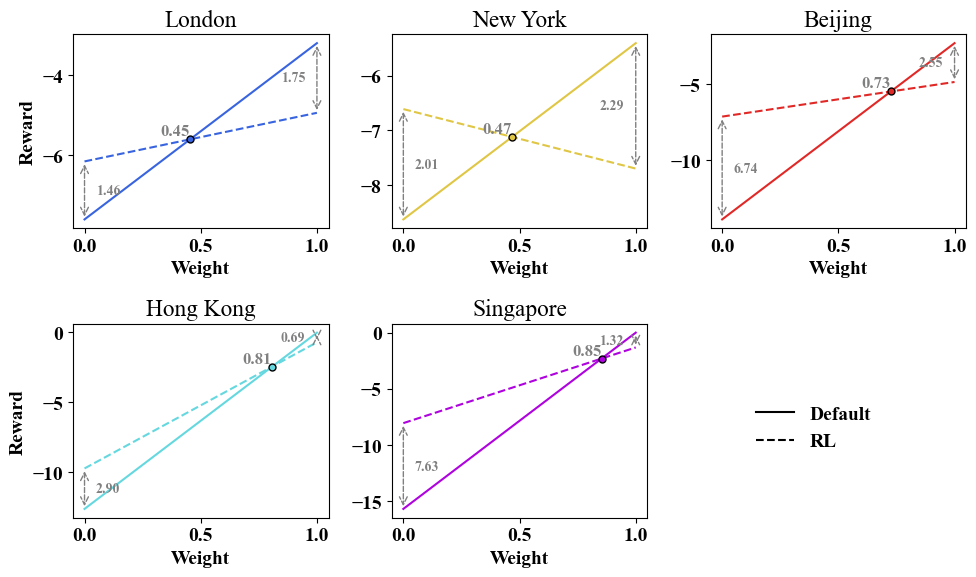

In [7]:

colors = ["#3964DF", "#E0C645","#E02927",  "#65D8DF", "#AE02DE"]
coordinates=[
    ["51.5118","-0.1167"],
    ["40.71427", "-74.00597"],
    ["39.9041999", "116.4073963"],
    ["22.396428", "114.109497"],
    ["1.36666666", "103.8"]]
coordinates = np.array(coordinates, dtype=float)

fig = plt.figure(figsize=(10, 6))
W_intersect = np.zeros(5)
for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(W, R[:,i], color=colors[i])
    ax.plot(W, R_rl[:,i], color=colors[i], linestyle='--')
    
    #  w=0 and w=1
    #ax.plot(W[0], R[0, i], 'o', color=colors[i])
    #ax.text(W[0], R[0, i], f'{R[0, i]:.2f}', fontsize=10, ha='left', va='bottom', color='grey')
    #ax.plot(W[-1], R[-1, i], 'o', color=colors[i])
    #ax.text(W[-1], R[-1, i], f'{R[-1, i]:.2f}', fontsize=10, ha='right', va='bottom', color='grey')
    #
    #ax.plot(W[0], R_rl[0, i], 'o', color=colors[i])
    #ax.text(W[0], R_rl[0, i], f'{R_rl[0, i]:.2f}', fontsize=10, ha='left', va='bottom', color='grey')
    #ax.plot(W[-1], R_rl[-1, i], 'o', color=colors[i])
    #ax.text(W[-1], R_rl[-1, i], f'{R_rl[-1, i]:.2f}', fontsize=10, ha='right', va='bottom', color='grey')
    
    # 绘制 w=0 的箭头和差值
    y_diff_start = abs(R[0, i] - R_rl[0, i])
    ax.annotate('', xy=(W[0], R[0, i]), xytext=(W[0], R_rl[0, i]),
                arrowprops=dict(arrowstyle='<->', color='grey', linestyle='dashed'))
    ax.text(W[0]+0.05, (R[0, i] + R_rl[0, i]) / 2, f'{y_diff_start:.2f}',
            fontsize=10, ha='left', va='center', color='grey')

    # 绘制 w=1 的箭头和差值
    y_diff_end = abs(R[-1, i] - R_rl[-1, i])
    ax.annotate('', xy=(W[-1], R[-1, i]), xytext=(W[-1], R_rl[-1, i]),
                arrowprops=dict(arrowstyle='<->', color='grey', linestyle='dashed'))
    ax.text(W[-1]-0.05, (R[-1, i] + R_rl[-1, i]) / 2, f'{y_diff_end:.2f}',
            fontsize=10, ha='right', va='center', color='grey')
    
    
    # Find the intersection points
    diff = R[:, i] - R_rl[:, i]
    sign_changes = np.where(np.diff(np.sign(diff)))[0]
    intersections = []
    for idx in sign_changes:
        w1, w2 = W[idx], W[idx + 1]
        r1, r2 = R[idx, i], R_rl[idx, i]
        r1_next, r2_next = R[idx + 1, i], R_rl[idx + 1, i]
        
        # Linear interpolation for more accurate intersection
        w_intersect = w1 + (w2 - w1) * abs(r1 - r2) / (abs(r1 - r2) + abs(r1_next - r2_next))
        r_intersect = r1 + (r1_next - r1) * (w_intersect - w1) / (w2 - w1)
        intersections.append((w_intersect, r_intersect))
        
        W_intersect[i] = w_intersect
    
    # Plot the intersections
    for w_intersect, r_intersect in intersections:
        ax.plot(w_intersect, r_intersect, 'o', markersize=5, color=colors[i], markeredgecolor='black')
        ax.text(w_intersect, r_intersect, f'{w_intersect:.2f}', fontsize=12, ha='right', va='bottom', color='grey')
    
    
    ax.set_xlabel('Weight')
    ax.set_title(list(cities_label.keys())[i])
    if i == 0:
        ax.plot([], [], '-', label='Default', color='black')
        ax.plot([], [], '--', label='RL', color='black')
        
        ax.set_ylabel('Reward') 
        
    if i == 3:
        ax.set_ylabel('Reward')
        
fig.legend(loc='lower right',
           ncol=1, frameon=False, bbox_to_anchor=(0.9, 0.2))

plt.tight_layout()
fig.savefig('./figs/w_sens.pdf', dpi=300, bbox_inches='tight')

/tmp/ipykernel_2409422/717897151.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels)


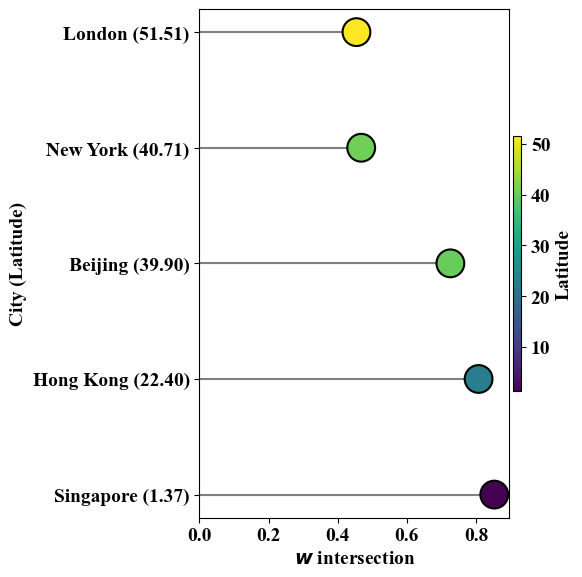

In [8]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1)

ax.hlines(y=list(cities_label.keys()), xmin=0, xmax=W_intersect[::-1], color='grey', zorder=0)
sc = ax.scatter(W_intersect, 
           list(cities_label.keys())[::-1], 
           c=coordinates[:, 0],
           #s=coordinates[:, 0] * 10, 
           s=400,
           edgecolors='black', linewidths=1.5, zorder=1)
ax.set_xlim(0)

#ax.set_xlabel('w intersection')# w 设置为斜体
ax.set_xlabel(r'$\it{w}$ intersection')

cbar = plt.colorbar(sc, pad=0.01, aspect=30, shrink=0.5)
cbar.set_label('Latitude')

yticklabels = list(cities_label.keys())[::-1]
yticklabels = [f'{city} ({lat:.2f})' for city, lat in zip(yticklabels, coordinates[:, 0][::-1])]
ax.set_yticklabels(yticklabels)
ax.set_ylabel('City (Latitude)')
plt.tight_layout()
fig.savefig('./figs/lat_w_intersect.pdf', dpi=300, bbox_inches='tight')
plt.show()